# Rasch (Nx1PL) MLTM
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [13]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt
from random import random, shuffle, choice, randint, uniform
import numpy

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

nq = 10
n_traits = 5



Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [14]:
generate_student_name()

'THAV GEC '

In [15]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }


class ProductLayer(Layer):

    def __init__(self, output_dim, kernel_constraint=WeightClip(min_w=-4.0, max_w=4.0), minv=-4,maxv=4, **kwargs):
        
        self.output_dim = output_dim
        super(ProductLayer, self).__init__(**kwargs)
        self.kernel_constraint= constraints.get(kernel_constraint)
        self.min_v = minv
        self.max_v = maxv

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, self.output_dim),
                                      initializer=initializers.RandomUniform(minval=self.min_v,maxval=self.max_v),
#                                       initializer=initializers.Constant(value=2.0),
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        
        super(ProductLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        z = K.concatenate([x,self.kernel], axis=0)
        p = K.prod(z, axis=0)
        return p

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [16]:
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print( 1/(1+exp(-z)) )

2.0611536181902037e-09
4.5397868702434395e-05
0.01798620996209156
0.04742587317756678
0.11920292202211755
0.2689414213699951
0.5
0.7310585786300049
0.8807970779778823
0.9525741268224334
0.9820137900379085


In [80]:
q_nw_width = 1
class Question():
    def __init__(self, qix, nt=10, optimiser=None):
        #self.MAX_BETA = 15
        self.id = qix
        no_dummies = randint(1,(nt-1))
        print("no_dummies=",no_dummies)
        not_present=-20
        min_diff = 0
        max_diff = 8
        self.betas = [ not_present for _ in range(nt) ]
        print("nt=",nt)
        choices = [ x for x in range(nt) ]
        for _ in range(no_dummies):
            ch = random.choice(choices)
            choices.remove(ch)
            self.betas[ch]=randint(min_diff,max_diff)
        #print("Made q with betas:", self.betas)
        
        th = Input(shape=(q_nw_width,), name="user_theta")
        b_in = Input(shape=(q_nw_width,), name="beta_in")
        bvar = ProductLayer(q_nw_width
                            , kernel_constraint=WeightClip(min_w=not_present, max_w=max_diff), minv=not_present,maxv=max_diff) # introduce nt trainable weights for the beta values
        b = bvar(b_in)
        dif = subtract([th,b])
        print("dif",dif.shape)
#         Pr = Dense(1, activation="sigmoid")(dif)
        Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="Pr_sigmoid")(dif)
        print("Prs",Prs.shape)
        Pr = Lambda(lambda ps: K.prod(ps, axis=1), name="Pr_prod")(Prs)
        print("Pr",Pr.shape)
        Pr = Reshape((1,))(Pr)
        print("Pr",Pr.shape)
        model = Model(inputs=[th,b_in], outputs=Pr)
#         o = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#         optimiser = Adam(lr=0.1)
        model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
        self.model = model
        self.pred_betas = bvar
        
        
# qs = [Question(qix, n_traits) for qix in range(10)]
# qs[0].model.summary()

# random.seed(666)
# qs = [Question(qix, n_traits) for qix in range(10)]
# for q in qs:
#     print(q.id, q.betas)

In [81]:
s_nw_width = 1
class Student():
    def __init__(self, nt=10, nq=20, optimiser=None):
        #self.MAX_BETA = 15
        self.name = generate_student_name()
        min_abil = 4
        max_abil = 12
        self.thetas = [ randint(min_abil, max_abil) for _ in range(nt) ]
        self.mastery = [0 for _ in range(nq)]
        self.o_practice = [0 for _ in range(nq)]
        self.h_practice = [0 for _ in range(nt)]
        #print("Made q with betas:", self.betas)
        th_in = Input(shape=(s_nw_width,), name="theta_in")
        b_in = Input(shape=(s_nw_width,), name="qn_beta")
        th_var = ProductLayer(s_nw_width, kernel_constraint=WeightClip(min_w=min_abil, max_w=max_abil), minv=min_abil, maxv=max_abil) # introduce nt trainable weights for the beta values
        th = th_var(th_in)
        dif = subtract([th,b_in])
        print("dif",dif.shape)
        Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="Pr_sigmoid")(dif)
        print("Prs",Prs.shape)
        Pr = Lambda(lambda ps: K.prod(ps, axis=1), name="Pr_prod")(Prs)
        print("Pr",Pr.shape)
        Pr = Reshape((1,))(Pr)
        model = Model(inputs=[th_in,b_in], outputs=Pr)
#         o = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#         optimiser= Adam(lr=0.1)
        model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
        self.model = model
        self.pred_theta = th_var

In [19]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=True
        student.mastery[q.id] = 1
    else:
        passed=False

    return passed

In [20]:
def calculate_pass_probability(thetas, betas):
    # additive factors model is:
    # p_pass = 1 / 1 + exp(-z)
    # where z = a + sum[1:n]( -b + gT )
    
    p_pass = 1.0
    print("th,b",thetas,betas)
    for th,b in zip(thetas,betas):
        if b < 0:
            continue
        z = (th-b)
        p_pass_step = 1.0 / (1.0 + exp(-z))
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:        
        print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
    #print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [82]:
random.seed(666)
qopt = Adam(lr=0.1)
master_qs = [Question(qix, nt=n_traits, optimiser=qopt) for qix in range(nq)]
for q in master_qs:
    nocomps = len(q.betas)
    mag = sqrt(sum([ pow(b, 2) for b in q.betas if b!=-10 ]))
    print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, nocomps))

no_dummies= 4
nt= 5
dif (?, 1)
Prs (?, 1)
Pr (?,)
Pr (?, 1)
no_dummies= 1
nt= 5
dif (?, 1)
Prs (?, 1)
Pr (?,)
Pr (?, 1)
no_dummies= 4
nt= 5
dif (?, 1)
Prs (?, 1)
Pr (?,)
Pr (?, 1)
no_dummies= 2
nt= 5
dif (?, 1)
Prs (?, 1)
Pr (?,)
Pr (?, 1)
no_dummies= 3
nt= 5
dif (?, 1)
Prs (?, 1)
Pr (?,)
Pr (?, 1)
no_dummies= 2
nt= 5
dif (?, 1)
Prs (?, 1)
Pr (?,)
Pr (?, 1)
no_dummies= 1
nt= 5
dif (?, 1)
Prs (?, 1)
Pr (?,)
Pr (?, 1)
no_dummies= 3
nt= 5
dif (?, 1)
Prs (?, 1)
Pr (?,)
Pr (?, 1)
no_dummies= 1
nt= 5
dif (?, 1)
Prs (?, 1)
Pr (?,)
Pr (?, 1)
no_dummies= 3
nt= 5
dif (?, 1)
Prs (?, 1)
Pr (?,)
Pr (?, 1)
Q:0, difficulty=23.77 across 5 components
Q:1, difficulty=40.45 across 5 components
Q:2, difficulty=20.37 across 5 components
Q:3, difficulty=35.90 across 5 components
Q:4, difficulty=28.46 across 5 components
Q:5, difficulty=35.55 across 5 components
Q:6, difficulty=40.00 across 5 components
Q:7, difficulty=30.23 across 5 components
Q:8, difficulty=40.45 across 5 components
Q:9, difficulty=29.21 

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [83]:
Xs = {}
Tz = {}
ys = {}
alphas = {}
attempts = []
attempts_by_psi = {}
attempts_by_q = {}
no_tr_students = 100

# psi_opt = Adam(lr=0.1)
random.seed(666)
psi_list = [ Student(nt=n_traits, nq=len(master_qs), optimiser=qopt) for _ in range(no_tr_students)]
for psi in psi_list:
    print(psi.name, psi.thetas)
    
    

dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)
Prs (?, 1)
Pr (?,)
dif (?, 1)

In [23]:
extend_pop=False
extend_by = 90
if extend_pop:
    for _ in range(extend_by):
        nu_psi = Student(nt=n_traits, nq=len(master_qs), optimiser=psi_opt)
        psi_list.append(nu_psi)

In [84]:
user_budget = 100
user_patience = 10
for run in range(1):
    print("----{}\n".format(run))
    for psi in psi_list:
        spend=0
        psi.mastery = [0 for _ in range(nq)]
        qs = [ix for ix in range(len(master_qs))]
        print("* * * **** USER {}".format(psi.name))
        print("* * * * ** THETAS {}".format(psi.thetas))
            
        while(True):
            q_ct = 0
            qix = random.choice(qs)
            q = master_qs[qix]
            passed=False

            if psi.name not in attempts_by_psi:
                attempts_by_psi[psi.name]=[]
            
            if q not in attempts_by_q:
                attempts_by_q[q]=[]

            while not passed and q_ct<user_patience:
                passed = attempt_q(psi, q)
                tup = (psi, q, passed)
                #attempts.append(tup)
                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)
                q_ct+=1

            if passed:
                print("passed")
                qs.remove(qix)
        
            spend += 1
        
            if qs == [] or spend>=user_budget:
                    print("* ** *QFIN USER {}".format(psi.name))
                    break
                    
import gc
gc.collect()

----0

* * * **** USER PHUTHY CORE 
* * * * ** THETAS [4, 5, 8, 5, 8]
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [-20, -20, -20, 6, -20]
p_pass=0.2689414213699951
th,b [4, 5, 8, 5, 8] [-20, -20, -20, 6, -20]
p_pass=0.2689414213699951
th,b [4, 5, 8, 5, 8] [-20, -20, -20, 6, -20]
p_pass=0.2689414213699951
passed
th,b [4, 5, 8, 5, 8] [-20, 6, 

th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.0024164149509169975
th,b [4, 5, 8, 5, 8] [8, -20, 8, 6, 1]
p_pass=0.

p_pass=0.015740995255198988
th,b [6, 10, 8, 5, 5] [8, -20, 8, 6, 1]
p_pass=0.015740995255198988
th,b [6, 10, 8, 5, 5] [8, -20, 8, 6, 1]
p_pass=0.015740995255198988
th,b [6, 10, 8, 5, 5] [8, -20, 8, 6, 1]
p_pass=0.015740995255198988
th,b [6, 10, 8, 5, 5] [8, -20, 8, 6, 1]
p_pass=0.015740995255198988
th,b [6, 10, 8, 5, 5] [8, -20, 8, 6, 1]
p_pass=0.015740995255198988
th,b [6, 10, 8, 5, 5] [1, -20, 1, 2, 3]
p_pass=0.8326497632095698
th,b [6, 10, 8, 5, 5] [1, -20, 1, 2, 3]
p_pass=0.8326497632095698
passed
th,b [6, 10, 8, 5, 5] [-20, 0, -20, -20, -20]
p_pass=0.9999546021312976
passed
th,b [6, 10, 8, 5, 5] [-20, -20, 6, 1, 4]
p_pass=0.6323326828120424
passed
th,b [6, 10, 8, 5, 5] [8, -20, 8, 6, 1]
p_pass=0.015740995255198988
th,b [6, 10, 8, 5, 5] [8, -20, 8, 6, 1]
p_pass=0.015740995255198988
th,b [6, 10, 8, 5, 5] [8, -20, 8, 6, 1]
p_pass=0.015740995255198988
th,b [6, 10, 8, 5, 5] [8, -20, 8, 6, 1]
p_pass=0.015740995255198988
th,b [6, 10, 8, 5, 5] [8, -20, 8, 6, 1]
p_pass=0.015740995255198988

p_pass=0.0021293964640152975
th,b [4, 8, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.0021293964640152975
th,b [4, 8, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.0021293964640152975
th,b [4, 8, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.0021293964640152975
th,b [4, 8, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.0021293964640152975
th,b [4, 8, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.0021293964640152975
th,b [4, 8, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.0021293964640152975
th,b [4, 8, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.0021293964640152975
th,b [4, 8, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.0021293964640152975
th,b [4, 8, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.0021293964640152975
th,b [4, 8, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.0021293964640152975
th,b [4, 8, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.0021293964640152975
th,b [4, 8, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.0021293964640152975
th,b [4, 8, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.0021293964640152975
th,b [4, 8, 6, 11, 10] [8, -20, 8, 6, 1]
p_pass=0.00212939646

p_pass=0.0035358671516615586
th,b [4, 6, 7, 7, 10] [8, -20, 8, 6, 1]
p_pass=0.0035358671516615586
th,b [4, 6, 7, 7, 10] [8, -20, 8, 6, 1]
p_pass=0.0035358671516615586
th,b [4, 6, 7, 7, 10] [8, -20, 8, 6, 1]
p_pass=0.0035358671516615586
th,b [4, 6, 7, 7, 10] [8, -20, 8, 6, 1]
p_pass=0.0035358671516615586
th,b [4, 6, 7, 7, 10] [8, -20, 8, 6, 1]
p_pass=0.0035358671516615586
th,b [4, 6, 7, 7, 10] [8, -20, 8, 6, 1]
p_pass=0.0035358671516615586
th,b [4, 6, 7, 7, 10] [8, -20, 8, 6, 1]
p_pass=0.0035358671516615586
th,b [4, 6, 7, 7, 10] [8, -20, 8, 6, 1]
p_pass=0.0035358671516615586
th,b [4, 6, 7, 7, 10] [8, -20, 8, 6, 1]
p_pass=0.0035358671516615586
th,b [4, 6, 7, 7, 10] [8, -20, 8, 6, 1]
p_pass=0.0035358671516615586
th,b [4, 6, 7, 7, 10] [8, -20, 8, 6, 1]
p_pass=0.0035358671516615586
th,b [4, 6, 7, 7, 10] [8, -20, 8, 6, 1]
p_pass=0.0035358671516615586
th,b [4, 6, 7, 7, 10] [8, -20, 8, 6, 1]
p_pass=0.0035358671516615586
th,b [4, 6, 7, 7, 10] [8, -20, 8, 6, 1]
p_pass=0.0035358671516615586
th,b 

p_pass=0.0049791864110913875
th,b [10, 11, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0049791864110913875
th,b [10, 11, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0049791864110913875
th,b [10, 11, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0049791864110913875
th,b [10, 11, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0049791864110913875
th,b [10, 11, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0049791864110913875
th,b [10, 11, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0049791864110913875
th,b [10, 11, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0049791864110913875
th,b [10, 11, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0049791864110913875
th,b [10, 11, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0049791864110913875
th,b [10, 11, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0049791864110913875
th,b [10, 11, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0049791864110913875
th,b [10, 11, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0049791864110913875
th,b [10, 11, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0049791864110913875
th,b [10, 11, 5, 4, 11] [8, -20, 8, 6, 1]
p_pass

th,b [6, 6, 4, 9, 4] [8, -20, 8, 6, 1]
p_pass=0.0019454681396466706
th,b [6, 6, 4, 9, 4] [8, -20, 8, 6, 1]
p_pass=0.0019454681396466706
th,b [6, 6, 4, 9, 4] [8, -20, 8, 6, 1]
p_pass=0.0019454681396466706
th,b [6, 6, 4, 9, 4] [8, -20, 8, 6, 1]
p_pass=0.0019454681396466706
th,b [6, 6, 4, 9, 4] [8, -20, 8, 6, 1]
p_pass=0.0019454681396466706
th,b [6, 6, 4, 9, 4] [8, -20, 8, 6, 1]
p_pass=0.0019454681396466706
th,b [6, 6, 4, 9, 4] [8, -20, 8, 6, 1]
p_pass=0.0019454681396466706
th,b [6, 6, 4, 9, 4] [8, -20, 8, 6, 1]
p_pass=0.0019454681396466706
th,b [6, 6, 4, 9, 4] [8, -20, 8, 6, 1]
p_pass=0.0019454681396466706
th,b [6, 6, 4, 9, 4] [8, -20, 8, 6, 1]
p_pass=0.0019454681396466706
th,b [6, 6, 4, 9, 4] [7, 4, -20, -20, 7]
p_pass=0.011234374488676696
th,b [6, 6, 4, 9, 4] [7, 4, -20, -20, 7]
p_pass=0.011234374488676696
th,b [6, 6, 4, 9, 4] [7, 4, -20, -20, 7]
p_pass=0.011234374488676696
th,b [6, 6, 4, 9, 4] [7, 4, -20, -20, 7]
p_pass=0.011234374488676696
th,b [6, 6, 4, 9, 4] [7, 4, -20, -20, 7]
p_p

p_pass=0.059547161028816624
th,b [4, 7, 4, 8, 4] [-20, -20, 6, 1, 4]
p_pass=0.059547161028816624
th,b [4, 7, 4, 8, 4] [-20, -20, 6, 1, 4]
p_pass=0.059547161028816624
th,b [4, 7, 4, 8, 4] [-20, -20, 6, 1, 4]
p_pass=0.059547161028816624
th,b [4, 7, 4, 8, 4] [-20, -20, 6, 1, 4]
p_pass=0.059547161028816624
th,b [4, 7, 4, 8, 4] [-20, -20, 6, 1, 4]
p_pass=0.059547161028816624
th,b [4, 7, 4, 8, 4] [-20, -20, 6, 1, 4]
p_pass=0.059547161028816624
th,b [4, 7, 4, 8, 4] [-20, -20, 6, 1, 4]
p_pass=0.059547161028816624
th,b [4, 7, 4, 8, 4] [8, 0, -20, -20, -20]
p_pass=0.017969823604022855
th,b [4, 7, 4, 8, 4] [8, 0, -20, -20, -20]
p_pass=0.017969823604022855
th,b [4, 7, 4, 8, 4] [8, 0, -20, -20, -20]
p_pass=0.017969823604022855
th,b [4, 7, 4, 8, 4] [8, 0, -20, -20, -20]
p_pass=0.017969823604022855
th,b [4, 7, 4, 8, 4] [8, 0, -20, -20, -20]
p_pass=0.017969823604022855
th,b [4, 7, 4, 8, 4] [8, 0, -20, -20, -20]
p_pass=0.017969823604022855
th,b [4, 7, 4, 8, 4] [8, 0, -20, -20, -20]
p_pass=0.01796982360

th,b [4, 7, 4, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.002142542534984327
th,b [4, 7, 4, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.002142542534984327
th,b [4, 7, 4, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.002142542534984327
th,b [4, 7, 4, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.002142542534984327
th,b [4, 7, 4, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.002142542534984327
th,b [4, 7, 4, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.002142542534984327
th,b [4, 7, 4, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.002142542534984327
th,b [4, 7, 4, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.002142542534984327
th,b [4, 7, 4, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.002142542534984327
th,b [4, 7, 4, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.002142542534984327
th,b [4, 7, 4, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.002142542534984327
th,b [4, 7, 4, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.002142542534984327
th,b [4, 7, 4, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.002142542534984327
th,b [4, 7, 4, 8, 4] [7, 4, -20, -20, 7]
p_pass=0.002142542534984327
th,b [4, 7, 4, 8, 4] [7, 4, -20, -

th,b [5, 12, 7, 12, 12] [8, -20, 8, 6, 1]
p_pass=0.012723031477129755
th,b [5, 12, 7, 12, 12] [8, -20, 8, 6, 1]
p_pass=0.012723031477129755
th,b [5, 12, 7, 12, 12] [8, -20, 8, 6, 1]
p_pass=0.012723031477129755
th,b [5, 12, 7, 12, 12] [8, -20, 8, 6, 1]
p_pass=0.012723031477129755
th,b [5, 12, 7, 12, 12] [8, -20, 8, 6, 1]
p_pass=0.012723031477129755
th,b [5, 12, 7, 12, 12] [8, -20, 8, 6, 1]
p_pass=0.012723031477129755
th,b [5, 12, 7, 12, 12] [8, -20, 8, 6, 1]
p_pass=0.012723031477129755
th,b [5, 12, 7, 12, 12] [8, -20, 8, 6, 1]
p_pass=0.012723031477129755
th,b [5, 12, 7, 12, 12] [8, -20, 8, 6, 1]
p_pass=0.012723031477129755
th,b [5, 12, 7, 12, 12] [8, -20, 8, 6, 1]
p_pass=0.012723031477129755
th,b [5, 12, 7, 12, 12] [8, -20, 8, 6, 1]
p_pass=0.012723031477129755
th,b [5, 12, 7, 12, 12] [8, -20, 8, 6, 1]
p_pass=0.012723031477129755
th,b [5, 12, 7, 12, 12] [8, -20, 8, 6, 1]
p_pass=0.012723031477129755
th,b [5, 12, 7, 12, 12] [8, -20, 8, 6, 1]
p_pass=0.012723031477129755
th,b [5, 12, 7, 12, 

th,b [4, 10, 5, 4, 4] [8, -20, 8, 6, 1]
p_pass=9.685915527608985e-05
th,b [4, 10, 5, 4, 4] [8, -20, 8, 6, 1]
p_pass=9.685915527608985e-05
th,b [4, 10, 5, 4, 4] [8, -20, 8, 6, 1]
p_pass=9.685915527608985e-05
th,b [4, 10, 5, 4, 4] [8, -20, 8, 6, 1]
p_pass=9.685915527608985e-05
th,b [4, 10, 5, 4, 4] [8, -20, 8, 6, 1]
p_pass=9.685915527608985e-05
th,b [4, 10, 5, 4, 4] [8, -20, 8, 6, 1]
p_pass=9.685915527608985e-05
th,b [4, 10, 5, 4, 4] [8, -20, 8, 6, 1]
p_pass=9.685915527608985e-05
th,b [4, 10, 5, 4, 4] [8, -20, 8, 6, 1]
p_pass=9.685915527608985e-05
th,b [4, 10, 5, 4, 4] [8, -20, 8, 6, 1]
p_pass=9.685915527608985e-05
th,b [4, 10, 5, 4, 4] [8, -20, 8, 6, 1]
p_pass=9.685915527608985e-05
th,b [4, 10, 5, 4, 4] [8, -20, 8, 6, 1]
p_pass=9.685915527608985e-05
th,b [4, 10, 5, 4, 4] [8, -20, 8, 6, 1]
p_pass=9.685915527608985e-05
th,b [4, 10, 5, 4, 4] [8, -20, 8, 6, 1]
p_pass=9.685915527608985e-05
th,b [4, 10, 5, 4, 4] [8, -20, 8, 6, 1]
p_pass=9.685915527608985e-05
th,b [4, 10, 5, 4, 4] [8, -20, 8, 

p_pass=0.041772570515350445
th,b [10, 12, 5, 5, 7] [-20, -20, 8, -20, 5]
p_pass=0.041772570515350445
th,b [10, 12, 5, 5, 7] [-20, -20, 8, -20, 5]
p_pass=0.041772570515350445
th,b [10, 12, 5, 5, 7] [-20, -20, 8, -20, 5]
p_pass=0.041772570515350445
th,b [10, 12, 5, 5, 7] [-20, -20, 8, -20, 5]
p_pass=0.041772570515350445
th,b [10, 12, 5, 5, 7] [-20, -20, 8, -20, 5]
p_pass=0.041772570515350445
th,b [10, 12, 5, 5, 7] [-20, -20, 8, -20, 5]
p_pass=0.041772570515350445
th,b [10, 12, 5, 5, 7] [-20, -20, 8, -20, 5]
p_pass=0.041772570515350445
th,b [10, 12, 5, 5, 7] [8, -20, 8, 6, 1]
p_pass=0.01120659611416569
th,b [10, 12, 5, 5, 7] [8, -20, 8, 6, 1]
p_pass=0.01120659611416569
th,b [10, 12, 5, 5, 7] [8, -20, 8, 6, 1]
p_pass=0.01120659611416569
th,b [10, 12, 5, 5, 7] [8, -20, 8, 6, 1]
p_pass=0.01120659611416569
th,b [10, 12, 5, 5, 7] [8, -20, 8, 6, 1]
p_pass=0.01120659611416569
th,b [10, 12, 5, 5, 7] [8, -20, 8, 6, 1]
p_pass=0.01120659611416569
th,b [10, 12, 5, 5, 7] [8, -20, 8, 6, 1]
p_pass=0.011

th,b [4, 4, 6, 9, 11] [8, -20, 8, 6, 1]
p_pass=0.002042234577616378
th,b [4, 4, 6, 9, 11] [8, -20, 8, 6, 1]
p_pass=0.002042234577616378
th,b [4, 4, 6, 9, 11] [8, -20, 8, 6, 1]
p_pass=0.002042234577616378
th,b [4, 4, 6, 9, 11] [8, -20, 8, 6, 1]
p_pass=0.002042234577616378
th,b [4, 4, 6, 9, 11] [8, -20, 8, 6, 1]
p_pass=0.002042234577616378
th,b [4, 4, 6, 9, 11] [8, -20, 8, 6, 1]
p_pass=0.002042234577616378
th,b [4, 4, 6, 9, 11] [8, -20, 8, 6, 1]
p_pass=0.002042234577616378
th,b [4, 4, 6, 9, 11] [8, -20, 8, 6, 1]
p_pass=0.002042234577616378
th,b [4, 4, 6, 9, 11] [8, -20, 8, 6, 1]
p_pass=0.002042234577616378
th,b [4, 4, 6, 9, 11] [8, -20, 8, 6, 1]
p_pass=0.002042234577616378
th,b [4, 4, 6, 9, 11] [8, -20, 8, 6, 1]
p_pass=0.002042234577616378
th,b [4, 4, 6, 9, 11] [8, -20, 8, 6, 1]
p_pass=0.002042234577616378
th,b [4, 4, 6, 9, 11] [8, -20, 8, 6, 1]
p_pass=0.002042234577616378
th,b [4, 4, 6, 9, 11] [8, -20, 8, 6, 1]
p_pass=0.002042234577616378
th,b [4, 4, 6, 9, 11] [8, -20, 8, 6, 1]
p_pass=0

th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [-20, -20, 8, -20, 5]
p_pass=0.013148973089827489
th,b [10, 7, 4, 4, 6] [-20, -20

p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b [10, 7, 4, 4, 6] [8, -20, 8, 6, 1]
p_pass=0.0018757976466163492
th,b 

th,b [4, 8, 4, 8, 10] [8, -20, 8, 6, 1]
p_pass=0.0002849059964651129
th,b [4, 8, 4, 8, 10] [8, -20, 8, 6, 1]
p_pass=0.0002849059964651129
th,b [4, 8, 4, 8, 10] [8, -20, 8, 6, 1]
p_pass=0.0002849059964651129
th,b [4, 8, 4, 8, 10] [8, -20, 8, 6, 1]
p_pass=0.0002849059964651129
th,b [4, 8, 4, 8, 10] [8, -20, 8, 6, 1]
p_pass=0.0002849059964651129
th,b [4, 8, 4, 8, 10] [8, -20, 8, 6, 1]
p_pass=0.0002849059964651129
th,b [4, 8, 4, 8, 10] [8, -20, 8, 6, 1]
p_pass=0.0002849059964651129
th,b [4, 8, 4, 8, 10] [8, -20, 8, 6, 1]
p_pass=0.0002849059964651129
th,b [4, 8, 4, 8, 10] [8, -20, 8, 6, 1]
p_pass=0.0002849059964651129
th,b [4, 8, 4, 8, 10] [8, -20, 8, 6, 1]
p_pass=0.0002849059964651129
th,b [4, 8, 4, 8, 10] [8, -20, 8, 6, 1]
p_pass=0.0002849059964651129
th,b [4, 8, 4, 8, 10] [8, -20, 8, 6, 1]
p_pass=0.0002849059964651129
th,b [4, 8, 4, 8, 10] [8, -20, 8, 6, 1]
p_pass=0.0002849059964651129
th,b [4, 8, 4, 8, 10] [8, -20, 8, 6, 1]
p_pass=0.0002849059964651129
th,b [4, 8, 4, 8, 10] [8, -20, 8, 

th,b [5, 6, 10, 9, 12] [7, 4, -20, -20, 7]
p_pass=0.10429087898839466
th,b [5, 6, 10, 9, 12] [7, 4, -20, -20, 7]
p_pass=0.10429087898839466
th,b [5, 6, 10, 9, 12] [7, 4, -20, -20, 7]
p_pass=0.10429087898839466
th,b [5, 6, 10, 9, 12] [7, 4, -20, -20, 7]
p_pass=0.10429087898839466
th,b [5, 6, 10, 9, 12] [8, 0, -20, -20, -20]
p_pass=0.04730860686532431
th,b [5, 6, 10, 9, 12] [8, 0, -20, -20, -20]
p_pass=0.04730860686532431
th,b [5, 6, 10, 9, 12] [8, 0, -20, -20, -20]
p_pass=0.04730860686532431
th,b [5, 6, 10, 9, 12] [8, 0, -20, -20, -20]
p_pass=0.04730860686532431
th,b [5, 6, 10, 9, 12] [8, 0, -20, -20, -20]
p_pass=0.04730860686532431
th,b [5, 6, 10, 9, 12] [8, 0, -20, -20, -20]
p_pass=0.04730860686532431
th,b [5, 6, 10, 9, 12] [8, 0, -20, -20, -20]
p_pass=0.04730860686532431
th,b [5, 6, 10, 9, 12] [8, 0, -20, -20, -20]
p_pass=0.04730860686532431
passed
th,b [5, 6, 10, 9, 12] [8, -20, 8, 6, 1]
p_pass=0.039790805309663994
passed
th,b [5, 6, 10, 9, 12] [1, -20, 1, 2, 3]
p_pass=0.98087701058

p_pass=0.0008320628693307082
th,b [5, 8, 4, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0008320628693307082
th,b [5, 8, 4, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0008320628693307082
th,b [5, 8, 4, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0008320628693307082
th,b [5, 8, 4, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0008320628693307082
th,b [5, 8, 4, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0008320628693307082
th,b [5, 8, 4, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0008320628693307082
th,b [5, 8, 4, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0008320628693307082
th,b [5, 8, 4, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0008320628693307082
th,b [5, 8, 4, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0008320628693307082
th,b [5, 8, 4, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0008320628693307082
th,b [5, 8, 4, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0008320628693307082
th,b [5, 8, 4, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0008320628693307082
th,b [5, 8, 4, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0008320628693307082
th,b [5, 8, 4, 10, 6] [8, -20, 8, 6, 1]
p_pass=0.0008320628693307082
th,b 

th,b [4, 6, 6, 8, 9] [8, -20, 8, 6, 1]
p_pass=0.001887803384256014
th,b [4, 6, 6, 8, 9] [8, -20, 8, 6, 1]
p_pass=0.001887803384256014
th,b [4, 6, 6, 8, 9] [8, -20, 8, 6, 1]
p_pass=0.001887803384256014
th,b [4, 6, 6, 8, 9] [8, -20, 8, 6, 1]
p_pass=0.001887803384256014
th,b [4, 6, 6, 8, 9] [8, -20, 8, 6, 1]
p_pass=0.001887803384256014
th,b [4, 6, 6, 8, 9] [8, -20, 8, 6, 1]
p_pass=0.001887803384256014
th,b [4, 6, 6, 8, 9] [8, -20, 8, 6, 1]
p_pass=0.001887803384256014
th,b [4, 6, 6, 8, 9] [8, -20, 8, 6, 1]
p_pass=0.001887803384256014
th,b [4, 6, 6, 8, 9] [8, -20, 8, 6, 1]
p_pass=0.001887803384256014
th,b [4, 6, 6, 8, 9] [8, -20, 8, 6, 1]
p_pass=0.001887803384256014
th,b [4, 6, 6, 8, 9] [8, -20, 8, 6, 1]
p_pass=0.001887803384256014
th,b [4, 6, 6, 8, 9] [8, -20, 8, 6, 1]
p_pass=0.001887803384256014
th,b [4, 6, 6, 8, 9] [8, -20, 8, 6, 1]
p_pass=0.001887803384256014
th,b [4, 6, 6, 8, 9] [8, -20, 8, 6, 1]
p_pass=0.001887803384256014
th,b [4, 6, 6, 8, 9] [8, -20, 8, 6, 1]
p_pass=0.00188780338425

p_pass=0.03051037416670881
th,b [6, 10, 7, 9, 8] [8, -20, 8, 6, 1]
p_pass=0.03051037416670881
th,b [6, 10, 7, 9, 8] [8, -20, 8, 6, 1]
p_pass=0.03051037416670881
th,b [6, 10, 7, 9, 8] [8, -20, 8, 6, 1]
p_pass=0.03051037416670881
th,b [6, 10, 7, 9, 8] [-20, -20, 6, 1, 4]
p_pass=0.7176688544602965
passed
th,b [6, 10, 7, 9, 8] [8, -20, 8, 6, 1]
p_pass=0.03051037416670881
th,b [6, 10, 7, 9, 8] [8, -20, 8, 6, 1]
p_pass=0.03051037416670881
th,b [6, 10, 7, 9, 8] [8, -20, 8, 6, 1]
p_pass=0.03051037416670881
th,b [6, 10, 7, 9, 8] [8, -20, 8, 6, 1]
p_pass=0.03051037416670881
th,b [6, 10, 7, 9, 8] [8, -20, 8, 6, 1]
p_pass=0.03051037416670881
th,b [6, 10, 7, 9, 8] [8, -20, 8, 6, 1]
p_pass=0.03051037416670881
th,b [6, 10, 7, 9, 8] [8, -20, 8, 6, 1]
p_pass=0.03051037416670881
th,b [6, 10, 7, 9, 8] [8, -20, 8, 6, 1]
p_pass=0.03051037416670881
th,b [6, 10, 7, 9, 8] [8, -20, 8, 6, 1]
p_pass=0.03051037416670881
th,b [6, 10, 7, 9, 8] [8, -20, 8, 6, 1]
p_pass=0.03051037416670881
th,b [6, 10, 7, 9, 8] [8, -

p_pass=0.04738266577916287
th,b [5, 7, 10, 9, 5] [8, 0, -20, -20, -20]
p_pass=0.04738266577916287
th,b [5, 7, 10, 9, 5] [8, 0, -20, -20, -20]
p_pass=0.04738266577916287
th,b [5, 7, 10, 9, 5] [8, 0, -20, -20, -20]
p_pass=0.04738266577916287
passed
th,b [5, 7, 10, 9, 5] [7, 4, -20, -20, 7]
p_pass=0.013535446422199436
th,b [5, 7, 10, 9, 5] [7, 4, -20, -20, 7]
p_pass=0.013535446422199436
th,b [5, 7, 10, 9, 5] [7, 4, -20, -20, 7]
p_pass=0.013535446422199436
th,b [5, 7, 10, 9, 5] [7, 4, -20, -20, 7]
p_pass=0.013535446422199436
th,b [5, 7, 10, 9, 5] [7, 4, -20, -20, 7]
p_pass=0.013535446422199436
th,b [5, 7, 10, 9, 5] [7, 4, -20, -20, 7]
p_pass=0.013535446422199436
th,b [5, 7, 10, 9, 5] [7, 4, -20, -20, 7]
p_pass=0.013535446422199436
th,b [5, 7, 10, 9, 5] [7, 4, -20, -20, 7]
p_pass=0.013535446422199436
th,b [5, 7, 10, 9, 5] [7, 4, -20, -20, 7]
p_pass=0.013535446422199436
th,b [5, 7, 10, 9, 5] [7, 4, -20, -20, 7]
p_pass=0.013535446422199436
th,b [5, 7, 10, 9, 5] [7, 4, -20, -20, 7]
p_pass=0.01

p_pass=0.028237124093151007
th,b [6, 6, 11, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.028237124093151007
th,b [6, 6, 11, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.028237124093151007
th,b [6, 6, 11, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.028237124093151007
th,b [6, 6, 11, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.028237124093151007
th,b [6, 6, 11, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.028237124093151007
th,b [6, 6, 11, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.028237124093151007
th,b [6, 6, 11, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.028237124093151007
th,b [6, 6, 11, 12, 5] [-20, 6, -20, -20, -20]
p_pass=0.5
passed
th,b [6, 6, 11, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.028237124093151007
th,b [6, 6, 11, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.028237124093151007
th,b [6, 6, 11, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.028237124093151007
th,b [6, 6, 11, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.028237124093151007
th,b [6, 6, 11, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.028237124093151007
th,b [6, 6, 11, 12, 5] [7, 4, -20, -20, 7]
p_pass=0.028

p_pass=0.0006738596032329461
th,b [5, 7, 6, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0006738596032329461
th,b [5, 7, 6, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0006738596032329461
th,b [5, 7, 6, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0006738596032329461
th,b [5, 7, 6, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0006738596032329461
th,b [5, 7, 6, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0006738596032329461
th,b [5, 7, 6, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0006738596032329461
th,b [5, 7, 6, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0006738596032329461
th,b [5, 7, 6, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0006738596032329461
th,b [5, 7, 6, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0006738596032329461
th,b [5, 7, 6, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0006738596032329461
th,b [5, 7, 6, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0006738596032329461
th,b [5, 7, 6, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0006738596032329461
th,b [5, 7, 6, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0006738596032329461
th,b [5, 7, 6, 4, 11] [8, -20, 8, 6, 1]
p_pass=0.0006738596032329461
th,b 

th,b [5, 7, 10, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.005385189847123658
th,b [5, 7, 10, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.005385189847123658
th,b [5, 7, 10, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.005385189847123658
th,b [5, 7, 10, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.005385189847123658
th,b [5, 7, 10, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.005385189847123658
th,b [5, 7, 10, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.005385189847123658
th,b [5, 7, 10, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.005385189847123658
th,b [5, 7, 10, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.005385189847123658
th,b [5, 7, 10, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.005385189847123658
th,b [5, 7, 10, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.005385189847123658
th,b [5, 7, 10, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.005385189847123658
th,b [5, 7, 10, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.005385189847123658
th,b [5, 7, 10, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.005385189847123658
th,b [5, 7, 10, 7, 4] [7, 4, -20, -20, 7]
p_pass=0.005385189847123658
th,b [5, 7, 10, 7, 4

3879

In [85]:
obi = numpy.ones(1)
es = EarlyStopping(monitor="loss", mode="auto")

random.seed(666)
calibration_mode = "NEURAL"
repz = (10 if calibration_mode=="NEURAL" else 1)
es = EarlyStopping(monitor="loss", mode="auto")
student_att_ct = Counter()
pat_ct = 10
b_del_tol = 0.001
th_del_tol = 0.001
last_th_rmse = 1000
last_b_rmse = 1000

b_del_tol = 0.0001
th_del_tol = 0.0001

last_mse = 1000

max_pat = 10
th_patience_ct = 0
b_patience_ct = 0

min_mse = 1000
min_avg_fit_rmse = 1000
mses=[]
accs=[]
q_outer_mses = []
q_outer_accs = []
s_outer_mses = []
s_outer_accs = []
theta_rmses = []
beta_rmses = []
avg_fit_rmses = []
losses = []

In [ ]:
import os

freeze_betas = False
freeze_thetas = False
for ix in range(70):
    q_clf_accs = []
    q_clf_mses = []
    q_clf_losses = []
    shuffle(master_qs)
    for q in master_qs:
        print(q.id)
        b_del = b_del_tol+1
        thetas = [ tup[0].pred_theta.get_weights()[0][0] for tup in attempts_by_q[q]]
        pfs = [ [tup[2]] for tup in attempts_by_q[q]]
        preb = q.pred_betas.get_weights()[0][0]
        if not freeze_betas:
            arr_thetas = array(thetas)
            arr_ones = numpy.ones(arr_thetas.shape)
            arr_pfs = array(pfs)
            print(arr_thetas.shape)
            print(arr_ones.shape)
            print(arr_pfs.shape)
            h = q.model.fit(x=[arr_thetas, arr_ones], y=arr_pfs, verbose=0, batch_size=1, epochs=100, callbacks=[es])
            del h
            loss, mse, acc = q.model.evaluate(x=[arr_thetas, arr_ones], y=arr_pfs, verbose=0)
            q_clf_accs.append(acc)
            q_clf_mses.append(mse)
            q_clf_losses.append(loss)
        postb = q.pred_betas.get_weights()[0][0]
        print("q{} true({}), preb {} postb {}".format(q.id, q.betas, preb, postb))

    if not freeze_thetas:
#                 psi_sublist = [tup[0] for tup in attempts_by_q[q]]
#                 for _student in set(psi_sublist):
        s_clf_accs=[]
        s_clf_mses=[]
        s_clf_losses = []
        shuffle(psi_list)
        for _student in psi_list:
            th_del = th_del_tol+1
            betas = [ tup[1].pred_betas.get_weights()[0][0] for tup in attempts_by_psi[_student.name]]# if tup[1]==q]
            pfs = [ [tup[2]] for tup in attempts_by_psi[_student.name]]# if tup[1]==q]
            preth= _student.pred_theta.get_weights()[0][0] 
    #             while(th_del > tol):
    #             print("fit psi")
            arr_betas = array(betas)
            arr_ones = numpy.ones(arr_betas.shape)
            h = _student.model.fit([arr_ones, arr_betas],array(pfs), verbose=0, batch_size=1, epochs=100, callbacks=[es])
            del h
            loss, mse, acc = _student.model.evaluate([arr_ones, arr_betas],array(pfs), verbose=0)
            s_clf_accs.append(acc)
            s_clf_mses.append(mse)
            s_clf_losses.append(loss)
            postth= _student.pred_theta.get_weights()[0][0]
    #                 th_del = abs(postth - preth)
    #                 print("th_Del",th_del)
            print("s{}: true({}), {} -> {}".format(_student.name, _student.thetas, preth, postth))

    th_rmse = sqrt(mean([(numpy.sort(s.thetas) - numpy.sort(s.pred_theta.get_weights()[0][0]))**2 for s in psi_list]))
    b_rmse = sqrt(mean([(numpy.sort(q.betas) - numpy.sort(q.pred_betas.get_weights()[0][0]))**2 for q in master_qs]))

    avg_fit_rmse = (th_rmse + b_rmse)/2.0
    mse = (mean(s_clf_mses) + mean(q_clf_mses))/2.0
    acc = (mean(s_clf_accs) + mean(q_clf_accs)) /2.0
    loss = (mean(s_clf_losses) + mean(q_clf_losses)) /2.0
                
#     if (last_b_rmse - b_rmse) > b_del_tol:
#         last_b_rmse = b_rmse
#     else:
#         freeze_betas = True
#         input("BETAS FROZEN")

    print("iteration",ix)
    print("b rmse:", b_rmse, "del:", (beta_rmses[-1] - b_rmse) if beta_rmses else 0)
    print("th rmse: {} del: {}".format(th_rmse, (theta_rmses[-1] - th_rmse) if theta_rmses else 0))
    print("avg clf mse: {} del: {}".format(mse, (mses[-1] - mse) if mses else 0))
    print("avg clf loss {} del {}".format(loss, (losses[-1]-loss) if losses else 0))
    print("acc = {}".format(acc))
    theta_rmses.append(th_rmse)
    beta_rmses.append(b_rmse)
    mses.append(mse)
    accs.append(acc)
    avg_fit_rmses.append(avg_fit_rmse)
    s_outer_mses.append(mean(s_clf_mses))
    s_outer_accs.append(mean(s_clf_accs))
    q_outer_mses.append(mean(q_clf_mses))
    q_outer_accs.append(mean(q_clf_accs))
    losses.append(loss)
            
#     xs = range(len(theta_rmses))
#     plt.plot(xs, numpy.multiply(1,theta_rmses), 'r')
#     plt.plot(xs, beta_rmses, 'b')
#     plt.plot(xs, s_outer_accs, "g")
#     plt.plot(xs, s_outer_mses, "g--")
#     plt.plot(xs, q_outer_accs, "m")
#     plt.plot(xs, q_outer_mses, "m--")
#     plt.plot(xs, mses, "k")
#     plt.show()
#         theta_rmses.append(th_rmse)
#         beta_rmses.append(b_rmse)
#     else:
# #         freeze_thetas = True
# #         input("THETAS FROZEN")
 
# #     if freeze_betas and freeze_thetas: # NO MORE CHANGE POSSIBLE!
#         break

#     if (min_avg_fit_rmse > avg_fit_rmse):
#         min_avg_fit_rmse = avg_fit_rmse
    if(min_mse > mse):
        min_mse = mse
        patience_ct = 0
    else:
        patience_ct += 1
    if patience_ct > max_pat:
        print("patience exhausted:",max_pat,"iterations with no new clf MSE minimum")
#         break
        
    duration = .3  # second
    freq = 440  # Hz
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))
    
    gc.collect()
    
print("final beta rmse = {}".format(beta_rmses[-1]))
print("final theta rmse = {}".format(theta_rmses[-1]))
print("final avg fit rmse = {}".format(avg_fit_rmses[-1]))
print("final classifier mse = {}".format(mses[-1]))
print("final acc = {}".format(accs[-1]))
print("final loss = {}".format(losses[-1]))
print("min mse =", min_mse)

In [144]:
for m in [1, 1.5, 2, 2.5, 3]:
    duration = .1  # second
    freq = 440*m  # Hz
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))
import IPython
IPython.display.Audio("calibration_complete.mp3")

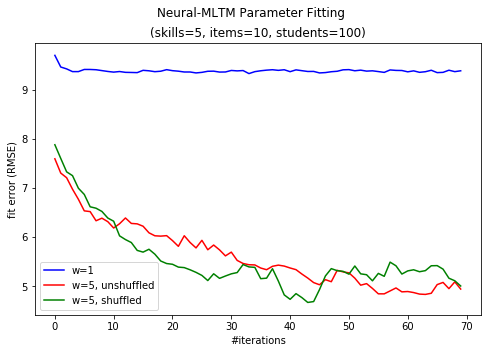

In [131]:
xs = range(len(theta_rmses[0:70]))
# plt.plot(xs, numpy.multiply(1,theta_rmses), 'b--')
# plt.plot(xs, numpy.multiply(1,beta_rmses), 'b')
plt.plot(xs, numpy.multiply(1,avg_fit_rmses[0:70]), "b", label="w=1")
plt.plot(xs, numpy.multiply(1,unshuffled_avg_fit_rmses[0:70]), "r", label="w=5, unshuffled")
plt.plot(xs, numpy.multiply(1,shuffled_avg_fit_rmses[0:70]), "g", label="w=5, shuffled")

# plt.plot(xs, accs, "m")
# plt.plot(xs, numpy.multiply(1,s_outer_accs), "g")
# plt.plot(xs, numpy.multiply(1,q_outer_accs), "k")

# plt.plot(xs, numpy.multiply(1,mses), "m--")
# plt.plot(xs, numpy.multiply(1,s_outer_mses), "g--")
# plt.plot(xs, numpy.multiply(1,q_outer_mses), "k--")
fig = plt.gcf()
fig.set_size_inches(8, 5)
plt.xlabel("#iterations")
plt.ylabel("fit error (RMSE)")
plt.suptitle("Neural-MLTM Parameter Fitting")
plt.title("(skills=5, items=10, students=100)")
plt.legend()
plt.show()

In [134]:
onewide_avg_fit_rmses #= avg_fit_rmses[0:70]
shuffled_avg_fit_rmses #= avg_fit_rmses[0:70]
unshuffled_avg_fit_rmses #= avg_fit_rmses[0:70]

import pandas
df = pandas.DataFrame()
df["1w"] = onewide_avg_fit_rmses
df["5w_shuff"] = shuffled_avg_fit_rmses
df["5w_unshuff"] = unshuffled_avg_fit_rmses
df.to_csv("rmses_for_k5_q10_s100.csv")